In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from dipy.core.gradients import gradient_table
from diGP.preprocessing_pipelines import get_SPARC_train_and_test
from diGP.dataManipulations import (DataHandler, log_q_squared)
from diGP.model import Model

%matplotlib inline
sns.set_style('dark')

In [4]:
dataPath = {'SPARC_20': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_20_nifti',
            'SPARC_30': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_30_nifti',
            'SPARC_60': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_60_nifti',
            'SPARC_GS': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\goldstandard_nifti'}
q_test_path = 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\EstimatedSignal_qvec.txt'

Load data to use for prediction.

In [5]:
source = 'SPARC_20'
gtab, data, voxelSize = get_SPARC_train_and_test(dataPath[source], dataPath['SPARC_GS'], q_test_path)

Loading SPARC data located at C:\Users\sesjojen\Documents\Data\SPARC\nifti\gradient_20_nifti
Checking for negative data.
Extracting b0 image.
Creating mask.
Normalizing data.
Loading SPARC data located at C:\Users\sesjojen\Documents\Data\SPARC\nifti\goldstandard_nifti
Checking for negative data.
Extracting b0 image.
Creating mask.
Normalizing data.


Fit a DTI model to use as the mean of the GP.

In [6]:
import dipy.reconst.dti as dti

tenmodel = dti.TensorModel(gtab['train'])
tenfit = tenmodel.fit(data['train'])

residuals = {'DTI': data['train'] - tenfit.predict(gtab['train'])}
pred = {'DTI': tenfit.predict(gtab['test'])}

In [15]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel

response = ((3e-3, 2e-4, 0), 1)
csd_model = ConstrainedSphericalDeconvModel(gtab['train'], response, sh_order=4)
csd_fit = csd_model.fit(data['train'])
residuals['CSD'] = data['train'] - csd_fit.predict(gtab['train'])
pred['CSD'] = csd_fit.predict(gtab['test'])

It is clear that there are spatial correlations in the residuals.

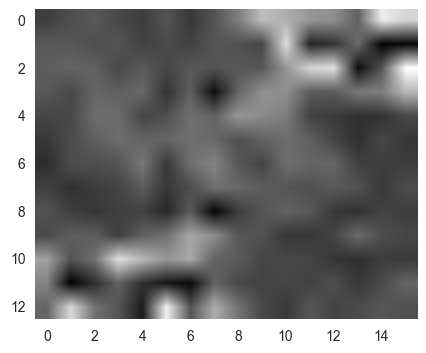

In [7]:
base_model = 'DTI'
plt.imshow(residuals[base_model][:,:,20])

In [8]:
lmbda=None
qMagnitudeTransform = None
handler = DataHandler(gtab['train'], residuals[base_model], qMagnitudeTransform=qMagnitudeTransform,
                      voxelSize=voxelSize[0:2], box_cox_lambda=lmbda)
handlerPred = DataHandler(gtab['test'], data=None, spatial_shape=data['test'].shape[0:2],
                          qMagnitudeTransform=qMagnitudeTransform, voxelSize=voxelSize[0:2], box_cox_lambda=lmbda)

In [9]:
spatialLengthScale = 5
bValLengthScale = 3

kernel = (GPy.kern.RBF(input_dim=1, active_dims=[0],
                       variance=1,
                       lengthscale=spatialLengthScale) *
          GPy.kern.RBF(input_dim=1, active_dims=[1],
                       variance=1,
                       lengthscale=spatialLengthScale) *
          GPy.kern.RBF(input_dim=1, active_dims=[2],
                            variance=1,
                            lengthscale=bValLengthScale) *
          GPy.kern.LegendrePolynomial(
             input_dim=3,
             coefficients=np.array((2, 0.5, 0.05)),
             orders=(0, 2, 4),
             active_dims=(3, 4, 5)))

kernel.parts[0].variance.fix(value=1)
kernel.parts[1].variance.fix(value=1)
kernel.parts[2].variance.fix(value=1)

grid_dims = [[0], [1], [2, 3, 4, 5]]

model = Model(handler, kernel, data_handler_pred=handlerPred, grid_dims=grid_dims, verbose=False)

In [10]:
np.random.seed(0)
model.train(restarts=True)

print(model.GP_model)
print("\nLegendre coefficients: \n{}".format(model.GP_model.mul.LegendrePolynomial.coefficients))

Optimization restart 1/10, f = -13560.248835868339
Optimization restart 2/10, f = -13560.248841081057
Optimization restart 3/10, f = -3211.7972292394115
Optimization restart 4/10, f = -13560.248840724818
Optimization restart 5/10, f = -13560.248841134076
Optimization restart 6/10, f = -13560.248841311715
Optimization restart 7/10, f = -13560.248828450445
Optimization restart 8/10, f = -13365.833282952013
Optimization restart 9/10, f = -13177.67180969137
Optimization restart 10/10, f = -13560.248841230228

Name : GP Grid regression
Objective : -13560.248841311715
Number of Parameters : 10
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_Grid_regression.                  |             value  |  constraints  |  priors
  mul.rbf.variance                     |               1.0  |   fixed +ve   |        
  mul.rbf.lengthscale                  |     1.70065501078  |      +ve      |        
  mul.rbf_1.variance                   |               1.0  |   fixed +ve   |     

In [11]:
mu = model.predict(compute_var=False)
pred_residuals = model.data_handler_pred.untransform(mu)

In [12]:
pred["{} + GP".format(base_model)] = pred[base_model] + pred_residuals

In [14]:
def get_SPARC_metrics(gtab, target, pred):
    bvals_in_range = (gtab.bvals <= 3500)  # 3500 instead of 3000 just to avoid round-off problems
    lowIdx = np.nonzero(bvals_in_range)
    highIdx = np.nonzero(np.invert(bvals_in_range))
    NMSE_low = compute_NMSE(target[:, :, lowIdx], pred[:, :, lowIdx])
    NMSE_high = compute_NMSE(target[:, :, highIdx], pred[:, :, highIdx])
    NMSE_all = compute_NMSE(target, pred)
    print("NMSE low: {}\nNMSE high: {}\nNMSE all: {}".format(NMSE_low, NMSE_high, NMSE_all))
    return NMSE_low, NMSE_high, NMSE_all

def compute_NMSE(target, pred):
    target = target.flatten()
    pred = pred.flatten()
    return np.mean(((target - pred)/target) **2)

for key, value in pred.items():
    print("\n{}:".format(key))
    get_SPARC_metrics(gtab['test'], data['test'], value)



DTI:
NMSE low: 0.07865178619130589
NMSE high: 0.24003453733688107
NMSE all: 0.14320488664953593

DTI + GP:
NMSE low: 0.01751071031268921
NMSE high: 0.07442880781606626
NMSE all: 0.040277949314040024
